In [1]:
import numpy as np
import pyproj
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 20

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

pyro.set_rng_seed(123)

from OkadaTorch import OkadaWrapper
okada = OkadaWrapper()

/fast/someya/miniforge3/envs/tsunami-NO/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate observation data (synthetic data + some noise)

In [2]:
# domain
lon_min, lon_max = 142, 148
lat_min, lat_max = 37, 43
dlon, dlat = 0.25, 0.25 # very sparse
nlon, nlat = int((lon_max-lon_min)/dlon)+1, int((lat_max-lat_min)/dlon)+1
lon_mid, lat_mid = (lon_min+lon_max)/2, (lat_min+lat_max)/2


# coordinate transformation
ll2xy = pyproj.Transformer.from_crs(
    crs_from="EPSG:4326", # WGS84
    crs_to=f"+proj=tmerc +lon_0={lon_mid} +lat_0={lat_mid} +ellps=WGS84 +datum=WGS84 +units=km", 
    always_xy=True
)

lon = np.linspace(lon_min, lon_max, nlon)
lat = np.linspace(lat_min, lat_max, nlat)
Lon, Lat = np.meshgrid(lon, lat)
x_obs, y_obs = ll2xy.transform(Lon, Lat)
X_obs = torch.from_numpy(x_obs)
Y_obs = torch.from_numpy(y_obs)

X_min, X_max = X_obs.min(), X_obs.max()
Y_min, Y_max = Y_obs.min(), Y_obs.max()
dX, dY = (X_max - X_min) / 2, (Y_max - Y_min) / 2
print(dX.item(), dY.item())

coords = {
    "x": X_obs,
    "y": Y_obs
}

267.0689477487547 335.28939693235236


In [3]:
# source parameters
lat_fault = 40.2224
lon_fault = 144.8678
x_fault, y_fault = ll2xy.transform(lon_fault, lat_fault)

print(x_fault, y_fault) # km

params_true = {
    "x_fault": torch.tensor(x_fault), # km
    "y_fault": torch.tensor(y_fault), # km
    "depth": torch.tensor(0.1), # km
    "length": torch.tensor(218.0), # km
    "width": torch.tensor(46.0), # km
    "strike": torch.tensor(189.0), # degree
    "dip": torch.tensor(60.0), # degree
    "rake": torch.tensor(270.0), # degree
    "slip": torch.tensor(5.62) # m
}

print("True parameters:")

for name in params_true.keys():
    value = params_true[name].item()
    print(name, value)

-11.25235992480785 24.70296061567198
True parameters:
x_fault -11.252360343933105
y_fault 24.702960968017578
depth 0.10000000149011612
length 218.0
width 46.0
strike 189.0
dip 60.0
rake 270.0
slip 5.619999885559082


In [4]:
ux_obs, uy_obs, uz_obs = okada.compute(coords, params_true, compute_strain=False, is_degree=True, fault_origin="topleft")

rng = np.random.default_rng(seed=123)
err = 0.05 * rng.standard_normal((nlon, nlat, 3))

ux_obs += torch.from_numpy(err[:, :, 0])
uy_obs += torch.from_numpy(err[:, :, 1])
uz_obs += torch.from_numpy(err[:, :, 2])

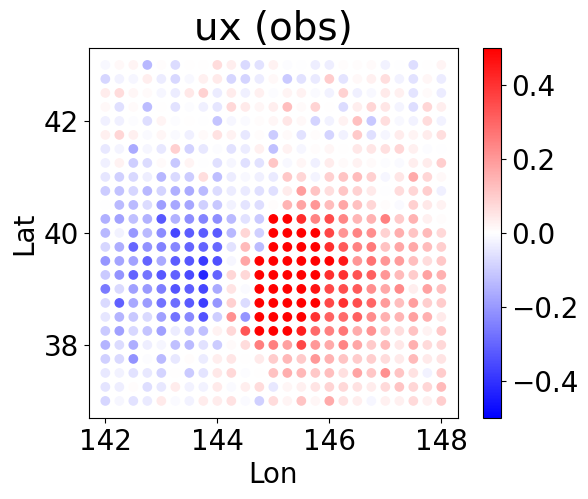

In [5]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=ux_obs, cmap="bwr", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("ux (obs)", fontsize=28)
fig.colorbar(im)
fig.show()

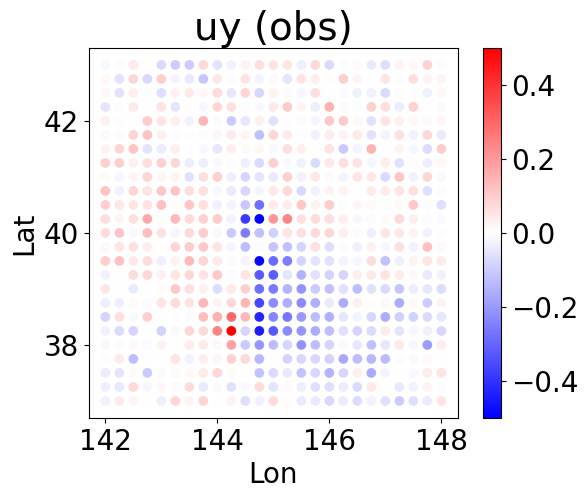

In [6]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=uy_obs, cmap="bwr", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("uy (obs)", fontsize=28)
fig.colorbar(im)
fig.show()

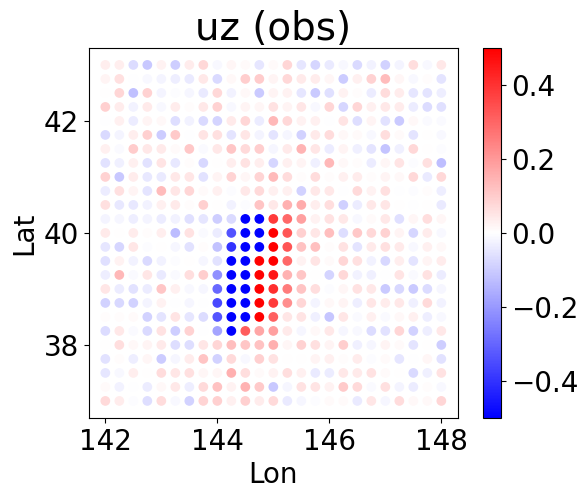

In [7]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=uz_obs, cmap="bwr", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("uz (obs)", fontsize=28)
fig.colorbar(im)
fig.show()

# Estimate `slip` using HMC-NUTS


The `HMC-NUTS` algorithm is used to obtain the posterior distribution of the fault parameters.
We use `pyro`, a Bayesian modeling package written with PyTorch.
Please refer to [pyro documentation](https://docs.pyro.ai/en/stable/) for the usage.


\* HMC = Hamiltonian Monte Carlo

\* NUTS = No U-Turn Sampler



We adopt another simple scaling: for each parameter `p`, we set lower value `p1` and upper value `p2` in advance.

The MCMC algorithm samples the normalized parameter `q ∈ [0,1]`. It is then transformed to actual dimensions `p = p1 + (p2-p1)*q` and input to `okada.compute`.

In [8]:
# choose appropriate lower/upper calues
p1 = {
    "x_fault": torch.tensor(x_fault-dX.item()/10),
    "y_fault": torch.tensor(y_fault-dY.item()/10),
    "depth": torch.tensor(0.0),
    "length": torch.tensor(150.0),
    "width": torch.tensor(25.0), 
    "strike": torch.tensor(150.0),
    "dip": torch.tensor(45.0), 
    "rake": torch.tensor(225.0),
    "slip": torch.tensor(3.0)
}
p2 = {
    "x_fault": torch.tensor(x_fault+dX.item()/10),
    "y_fault": torch.tensor(y_fault+dY.item()/10),
    "depth": torch.tensor(10.0),
    "length": torch.tensor(250.0),
    "width": torch.tensor(75.0), 
    "strike": torch.tensor(240.0),
    "dip": torch.tensor(90.0), 
    "rake": torch.tensor(315.0),
    "slip": torch.tensor(10.0)
}

print(p1)
print(p2)

{'x_fault': tensor(-37.9593), 'y_fault': tensor(-8.8260), 'depth': tensor(0.), 'length': tensor(150.), 'width': tensor(25.), 'strike': tensor(150.), 'dip': tensor(45.), 'rake': tensor(225.), 'slip': tensor(3.)}
{'x_fault': tensor(15.4545), 'y_fault': tensor(58.2319), 'depth': tensor(10.), 'length': tensor(250.), 'width': tensor(75.), 'strike': tensor(240.), 'dip': tensor(90.), 'rake': tensor(315.), 'slip': tensor(10.)}


In [9]:
u_obs = torch.stack([ux_obs, uy_obs, uz_obs])

params = {key: val.clone().detach() for key, val in params_true.items()}


# define model
def model():
    
    # prior
    for key in params:
        params[key] = p1[key] + (p2[key] - p1[key]) * pyro.sample(key, dist.Uniform(0.0, 1.0))

    # model prediction
    ux_pred, uy_pred, uz_pred = okada.compute(coords, params, compute_strain=False, is_degree=True, fault_origin="topleft")
    u_pred = torch.stack([ux_pred, uy_pred, uz_pred])

    # noise distribution 
    pyro.sample("obs", dist.Normal(u_pred, 0.05), obs=u_obs)

In [10]:
kernel = NUTS(model)
# [warning] num_samples=1000 is recommended (takes 30min). num_samples=10000 takes > 4hr. 
mcmc = MCMC(kernel, num_samples=10000, warmup_steps=200)
mcmc.run()
mcmc.summary()

Sample: 100%|██████████| 10200/10200 [4:24:03,  1.55s/it, step size=1.77e-02, acc. prob=0.908]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     depth      0.04      0.01      0.04      0.02      0.05   2647.48      1.00
       dip      0.33      0.00      0.33      0.32      0.34   3104.51      1.00
    length      0.66      0.00      0.66      0.66      0.67  11063.21      1.00
      rake      0.50      0.00      0.50      0.49      0.50   5230.63      1.00
      slip      0.39      0.01      0.39      0.38      0.40   4797.22      1.00
    strike      0.43      0.00      0.43      0.43      0.43   6608.89      1.00
     width      0.38      0.01      0.38      0.37      0.39   3309.32      1.00
   x_fault      0.47      0.00      0.47      0.47      0.47   4041.42      1.00
   y_fault      0.50      0.00      0.50      0.49      0.51   9694.62      1.00

Number of divergences: 19


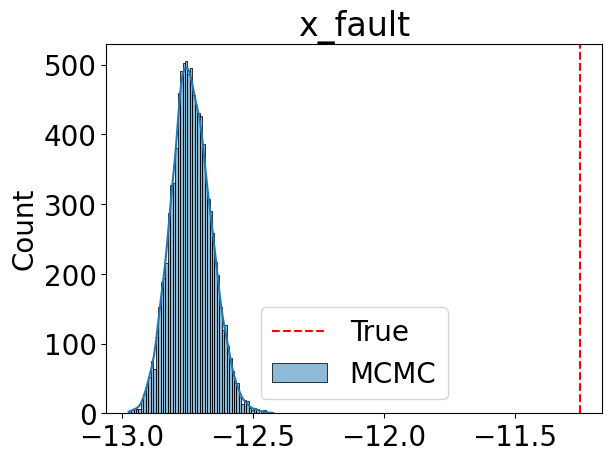

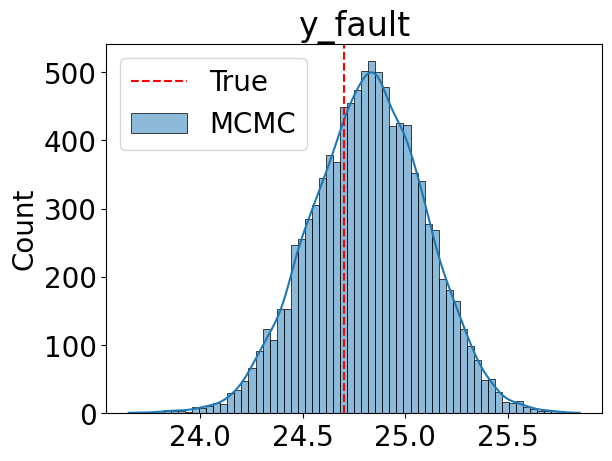

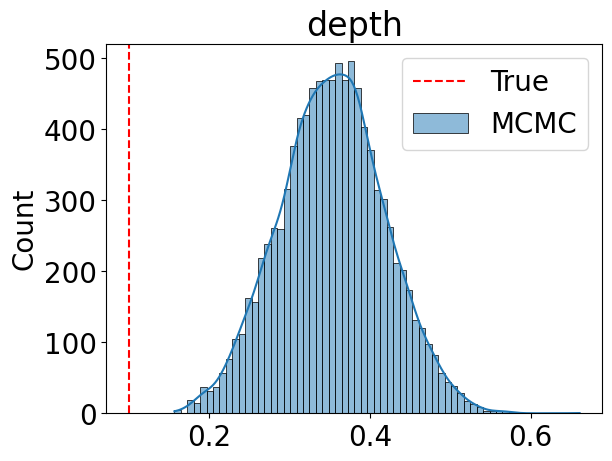

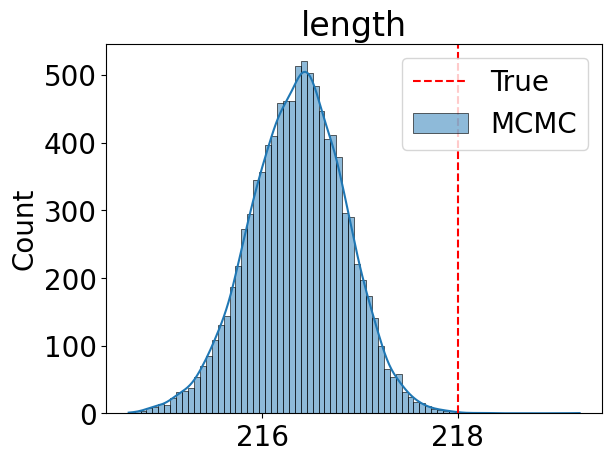

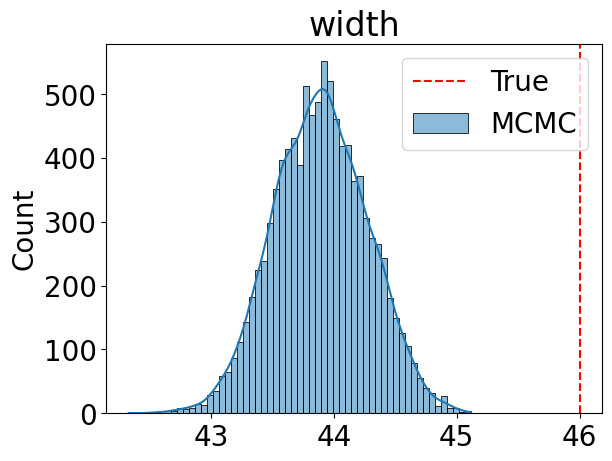

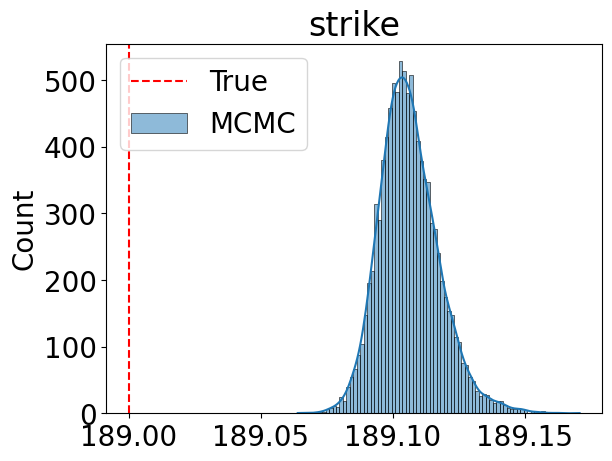

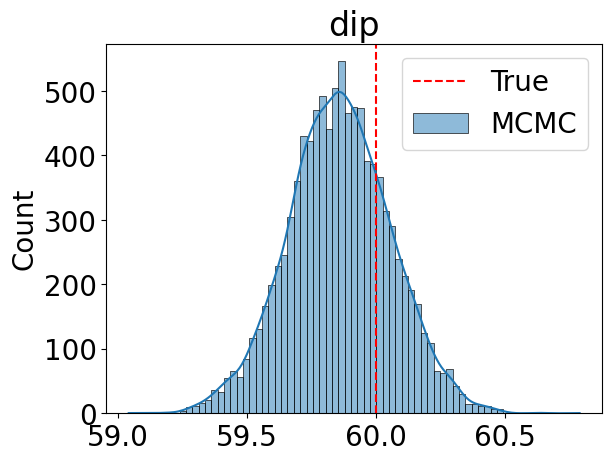

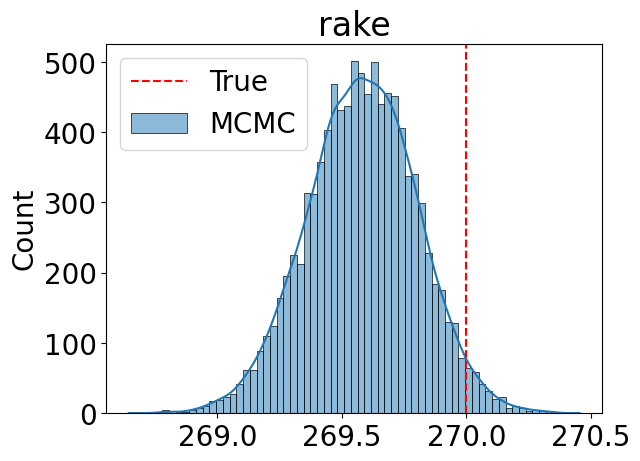

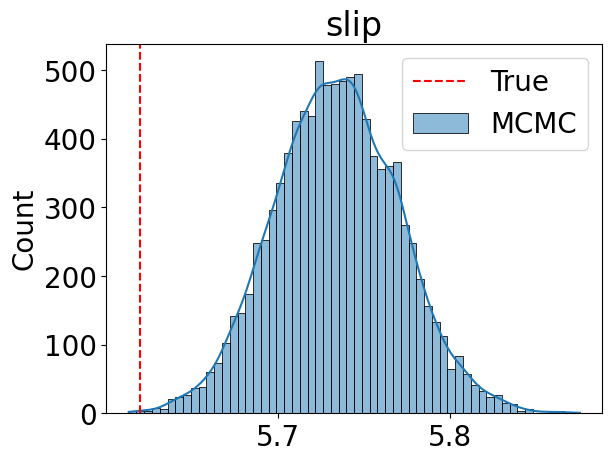

In [11]:
import seaborn as sns

posterior_samples = mcmc.get_samples()

for key in params_true: 
    p = p1[key] + (p2[key] - p1[key]) * posterior_samples[key]
    sns.histplot(p.numpy(), kde=True, label="MCMC")
    plt.axvline(params_true[key].item(), color='red', linestyle='--', label='True')
    plt.legend()
    plt.title(key)
    plt.show()